In [2]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

In [3]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction='in')
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction='in') 

        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [4]:
#################################################################
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

#################################################################

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod
#################################################################

def Vh2Vls(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    vls = Vh-26.*cosl*cosb+317.*sinl*cosb-8.*sinb

    return vls
#################################################################

In [5]:
leda = pd.read_csv('Leda_bar.csv', delimiter='|')
leda = leda.set_index('PGC')

print(len(leda))

/home/ehsan/anaconda3/envs/py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


397843


In [6]:
df = pd.read_csv('VirgoFornax_sbf.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df = df.set_index('PGC')

ln10 = np.log(10.)
df['DM_VirFor']  = df["DM"]
df['eDM_VirFor'] = df["e_dm"]
df = df.rename(columns={"PGC1": "PGC1_VirFor"})

print(len(df))

how = 'inner'
df_VirFor = df.join(leda, lsuffix='_VirFor', rsuffix='_leda', how=how)

print(len(df_VirFor))

df_VirFor["Vcmb_VirFor"] = Vh2V3k(df_VirFor["l2"], df_VirFor["b2"], df_VirFor["v"])

df_VirFor.head()

134
134


,PGC1_VirFor,J2000,Name,g-z,e_gz,m_sbf,e_msbf,DM,e_dm,dist,...,mabs,type,bar,ring,multiple,compactness,angclass,RA2000,DEC2000,Vcmb_VirFor
PGC,,,,,,,,,,,,,,,,,,,,,
12636,12651,J032222.7-372351,FCC19,1.066,0.025,29.258,0.036,31.532,0.074,20.2,...,0.0,1337.0,1306.0,1192.0,1310.0,31.25,31.53,-15.96,NaN,-66.296629
12651,12651,J032241.7-371230,FCC21,1.368,0.007,29.676,0.020,31.607,0.065,21.0,...,0.0,1701.0,1670.0,1556.0,1674.0,31.81,31.62,-22.52,NaN,-97.394762
12691,12651,J032337.3-354642,FCC26,0.830,0.025,28.974,0.055,31.491,0.139,19.9,...,1.3,1659.0,1625.0,1513.0,1624.0,31.75,0.00,-16.86,NaN,-67.737049
12825,12923,J032602.2-325340,FCC43,1.154,0.007,29.283,0.039,31.483,0.073,19.8,...,0.0,1256.0,1217.0,1108.0,1207.0,31.11,31.48,-17.41,NaN,-91.465693
12848,13418,J032632.2-354249,FCC47,1.298,0.013,29.271,0.040,31.314,0.075,18.3,...,0.0,1334.0,1301.0,1190.0,1304.0,31.25,31.32,-18.17,NaN,-102.492409


In [7]:
df = pd.read_csv('Hydra_Centaurus_sbf.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df = df.set_index('PGC')

ln10 = np.log(10.)
df['DM_HydCen']  = df["DM"]
df['eDM_HydCen'] = df["e_dm"]
df = df.rename(columns={"PGC1": "PGC1_HydCen"})

print(len(df))
how = 'inner'
df_HydCen = df.join(leda, lsuffix='_HydCen', rsuffix='_leda', how=how)
df_HydCen["Vcmb_HydCen"] = Vh2V3k(df_HydCen["l2"], df_HydCen["b2"], df_HydCen["Vh"])
print(len(df_HydCen))

df_HydCen.head()

31
31


,Name,PGC1_HydCen,Nest,GpID,RAJ,DeJ,Vo,V-I,Vh,Type,...,mabs,type,bar,ring,multiple,compactness,angclass,RA2000,DEC2000,Vcmb_HydCen
PGC,,,,,,,,,,,,,,,,,,,,,
31438,N3308,31478,100006,487,10 36 22.3,-27 26 17,12.10,1.28,3537,SB0(2)[SAB(s)0-],...,0.0,3275.0,3351.0,3414.0,3885.0,33.49,0.00,-20.49,NaN,3880.639884
31466,N3311,31478,100006,487,10 36 35.7,-27 31 05,11.90,1.21,4068,E1[E3],...,0.0,3809.0,3886.0,3948.0,4420.0,33.80,0.00,-21.65,NaN,4411.509218
31478,N3309,31478,100006,487,10 36 42.7,-27 31 42,10.90,1.15,3713,S0(2)[E+2],...,0.0,3555.0,3631.0,3694.0,4165.0,33.66,0.00,-21.27,NaN,4056.513803
43058,52,43296,100003,441,12 45 44.3,-41 02 58,17.86,1.09,2609,"dE,N",...,0.0,2327.0,2437.0,2453.0,2887.0,32.77,0.00,-17.54,NaN,2893.207165
43280,61,43296,100003,441,12 48 39.7,-41 16 05,16.26,1.14,2910,"dE,N",...,0.0,2570.0,2680.0,2696.0,3128.0,32.97,33.01,-16.20,NaN,3192.300680


In [8]:
df = pd.read_csv('Tonry_sbf.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df = df.set_index('PGC')

ln10 = np.log(10.)
df['DM_Tonry']  = df["Modc"]
df['eDM_Tonry'] = df["e_Mod"]
df = df.rename(columns={"PGC1": "PGC1_Tonry"})


print(len(df))
how = 'inner'
df_Tonry = df.join(leda, lsuffix='_Tonry', rsuffix='_leda', how=how)
df_Tonry["Vcmb_Tonry"] = Vh2V3k(df_Tonry["l2"], df_Tonry["b2"], df_Tonry["V_hel"])
print(len(df_Tonry))

df_Tonry.head()

297
297


,objname_Tonry,Modc,PGC1_Tonry,Nest,al2000_Tonry,de2000_Tonry,V_hel,T,GrpID,AgB,...,mabs,type,bar,ring,multiple,compactness,angclass,RA2000,DEC2000,Vcmb_Tonry
PGC,,,,,,,,,,,,,,,,,,,,,
218,N7814,30.45,218,211714,0.813,16.146,1059,2,0,0.19,...,3.39,1292.0,1200.0,1109.0,702.0,31.11,31.26,-20.15,NaN,701.544501
1160,N0063,31.30,1160,212242,4.440,11.449,1160,0,0,0.48,...,3.44,1388.0,1297.0,1197.0,820.0,31.25,31.36,-19.04,NaN,804.882440
2004,N0147,24.24,2557,0,8.298,48.508,-193,-5,282,0.75,...,0.00,103.0,-4.0,-2.0,-445.0,0.00,24.15,-14.30,NaN,-455.615596
2329,N0185,23.82,2557,0,9.742,48.338,-202,-5,282,0.79,...,7.77,92.0,-16.0,-13.0,-453.0,0.00,24.00,-14.65,NaN,-463.091804
2555,N0221,24.35,2557,0,10.675,40.865,-200,-6,282,0.35,...,0.00,91.0,-18.0,-36.0,-472.0,0.00,24.11,-15.89,NaN,-486.492109


In [9]:
df = pd.read_csv('HST_IR_sbf.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df = df.set_index('PGC')

ln10 = np.log(10.)
df['DM_HSTIR']  = df["DM"]
df['eDM_HSTIR'] = df["edm"]
df_HSTIR = df.rename(columns={"PGC1": "PGC1_HSTIR"})

df_HSTIR["Vcmb_HSTIR"] = Vh2V3k(df_HSTIR["glon"], df_HSTIR["glat"], df_HSTIR["Vhel"])

df_HSTIR.head()

,Name,PGC1_HSTIR,Nest,DM,edm,Vhel,Ty,RA_DEJ,glon,glat,sgl,sgb,Ag,DM_HSTIR,eDM_HSTIR,Vcmb_HSTIR
PGC,,,,,,,,,,,,,,,,
1037,NGC0057,1037,200319,34.126,0.074,5449,-4.9,J001530.9+171942,110.8305,-44.6976,310.9031,13.7833,0.335,34.126,0.074,5097.443600
3455,NGC0315,3455,200070,34.167,0.068,4974,-4.1,J005748.9+302108,124.5630,-32.4992,326.0060,7.2773,0.280,34.167,0.068,4666.687342
3982,NGC0383,4224,200005,34.100,0.076,5057,-2.9,J010724.9+322446,126.8388,-30.3378,328.5287,5.8072,0.307,34.100,0.076,4760.516577
4224,NGC0410,4224,200005,33.937,0.070,5276,-4.3,J011058.9+330908,127.6335,-29.5410,329.4427,5.2765,0.254,33.937,0.070,4983.628463
5037,NGC0495,5098,200006,34.049,0.059,4104,0.2,J012256.2+332813,130.4359,-28.9420,330.4440,2.9656,0.311,34.049,0.059,3820.698741


In [10]:
df = pd.read_csv('Cantiello18_sbf.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df = df.set_index('PGC')

ln10 = np.log(10.)
df['DM_Cantiello18']  = df["DM"]
df['eDM_Cantiello18'] = df["edm"]
df = df.rename(columns={"PGC1": "PGC1_Cantiello18"})

print(len(df))
how = 'inner'
df_Cantiello18 = df.join(leda, lsuffix='_Cantiello18', rsuffix='_leda', how=how)
df_Cantiello18["Vcmb_Cantiello18"] = Vh2V3k(df_Cantiello18["l2"], df_Cantiello18["b2"], df_Cantiello18["Vhel"])
print(len(df_Cantiello18))

df_Cantiello18.head()

89
89


,Name,VCC,dist,eD,DM,edm,Vhel,PGC1_Cantiello18,Nest,Gp,...,mabs,type,bar,ring,multiple,compactness,angclass,RA2000,DEC2000,Vcmb_Cantiello18
PGC,,,,,,,,,,,,,,,,,,,,,
38890,NGC4168,VCC0049,31.4,1.9,32.49,0.13,2273,38890,130002,M,...,0.00,2154.0,2214.0,2361.0,2604.0,32.70,0.00,-20.78,NaN,2608.863643
39246,NGC4216,VCC0167,18.1,1.9,31.29,0.23,134,41220,100002,V,...,2.78,14.0,75.0,221.0,462.0,0.00,30.88,-20.90,NaN,468.471293
39328,NGC4224,VCC0199,21.5,1.3,31.66,0.13,2587,39659,120002,W/W'?,...,3.77,2440.0,2509.0,2647.0,2924.0,32.94,33.24,-20.52,NaN,2931.871275
39384,NGC4233,VCC0220,31.1,2.2,32.46,0.15,2275,39659,120002,W,...,0.00,2131.0,2200.0,2338.0,2614.0,32.66,0.00,-19.81,NaN,2619.362026
39389,NGC4235,VCC0222,26.6,2.4,32.12,0.19,2423,39659,120002,W,...,3.00,2277.0,2346.0,2484.0,2762.0,32.80,31.27,-20.82,NaN,2768.027945


In [11]:
how = 'outer'
df = df_HSTIR.join(df_Tonry, lsuffix='_l0', rsuffix='_', how=how)
df = df.join(df_Cantiello18, lsuffix='_l1', rsuffix='_', how=how)
df = df.join(df_VirFor, lsuffix='_l2', rsuffix='_', how=how)
df = df.join(df_HydCen, lsuffix='_l3', rsuffix='_', how=how)
     

catalogs = ["VirFor", "Tonry", "Cantiello18", "HydCen", "HSTIR"]

ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat, "Vcmb_"+cat]

df = df[ss]

ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat]   
df['PGC1'] = df[ss].median(axis=1)
df = df[~df['PGC1'].isna()]

ss = []
for cat in catalogs:
    ss += ['Vcmb_'+cat]   
df['Vcmb'] = df[ss].mean(axis=1)


print(len(df))

# df[df[ss].count(axis=1)>1][ss]
df.head()

508


,PGC1_VirFor,Vcmb_VirFor,PGC1_Tonry,Vcmb_Tonry,PGC1_Cantiello18,Vcmb_Cantiello18,PGC1_HydCen,Vcmb_HydCen,PGC1_HSTIR,Vcmb_HSTIR,PGC1,Vcmb
PGC,,,,,,,,,,,,
218,NaN,NaN,218.0,701.544501,NaN,NaN,NaN,NaN,NaN,NaN,218.0,701.544501
1037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1037.0,5097.4436,1037.0,5097.443600
1160,NaN,NaN,1160.0,804.882440,NaN,NaN,NaN,NaN,NaN,NaN,1160.0,804.882440
2004,NaN,NaN,2557.0,-455.615596,NaN,NaN,NaN,NaN,NaN,NaN,2557.0,-455.615596
2329,NaN,NaN,2557.0,-463.091804,NaN,NaN,NaN,NaN,NaN,NaN,2557.0,-463.091804


In [12]:
dg = df.groupby('PGC1').agg(["mean", "count"])

dg.head()

PGC1_VirFor       Vcmb_VirFor       PGC1_Tonry         Vcmb_Tonry  \
              mean count        mean count       mean count         mean   
PGC1                                                                       
218.0          NaN     0         NaN     0      218.0     1   701.544501   
1037.0         NaN     0         NaN     0        NaN     0          NaN   
1160.0         NaN     0         NaN     0     1160.0     1   804.882440   
2557.0         NaN     0         NaN     0     2557.0     4  -497.584663   
2980.0         NaN     0         NaN     0     2980.0     1  1339.668891   

             PGC1_Cantiello18        ... PGC1_HydCen       Vcmb_HydCen        \
       count             mean count  ...        mean count        mean count   
PGC1                                 ...                                       
218.0      1              NaN     0  ...         NaN     0         NaN     0   
1037.0     0              NaN     0  ...         NaN     0         NaN     0   
1160.0     1              NaN     0  ...         NaN     0         NaN     0   
2557.0     4              NaN     0  ...         NaN     0         NaN     0   
2980.0     1              NaN     0  ...         NaN     0         NaN     0   

       PGC1_HSTIR       Vcmb_HSTIR               Vcmb        
             mean count       mean count         mean count  
PGC1                                                         
218.0         NaN     0        NaN     0   701.544501     1  
1037.0     1037.0     1  5097.4436     1  5097.443600     1  
1160.0        NaN     0        NaN     0   804.882440     1  
2557.0        NaN     0        NaN     0  -497.584663     4  
2980.0        NaN     0        NaN     0  1339.668891     1  

[5 rows x 22 columns]

In [13]:
dg.loc[218].Vcmb['count']

1.0

In [14]:
df["Vgrp"] = df["PGC1"].apply(lambda x: dg.loc[x].Vcmb['mean'])
df["Ngrp"] = df["PGC1"].apply(lambda x: dg.loc[x].Vcmb['count'])

df.head()

,PGC1_VirFor,Vcmb_VirFor,PGC1_Tonry,Vcmb_Tonry,PGC1_Cantiello18,Vcmb_Cantiello18,PGC1_HydCen,Vcmb_HydCen,PGC1_HSTIR,Vcmb_HSTIR,PGC1,Vcmb,Vgrp,Ngrp
PGC,,,,,,,,,,,,,,
218,NaN,NaN,218.0,701.544501,NaN,NaN,NaN,NaN,NaN,NaN,218.0,701.544501,701.544501,1.0
1037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1037.0,5097.4436,1037.0,5097.443600,5097.443600,1.0
1160,NaN,NaN,1160.0,804.882440,NaN,NaN,NaN,NaN,NaN,NaN,1160.0,804.882440,804.882440,1.0
2004,NaN,NaN,2557.0,-455.615596,NaN,NaN,NaN,NaN,NaN,NaN,2557.0,-455.615596,-497.584663,4.0
2329,NaN,NaN,2557.0,-463.091804,NaN,NaN,NaN,NaN,NaN,NaN,2557.0,-463.091804,-497.584663,4.0


In [15]:
df = df.sort_values(by=['Vgrp', 'PGC1'], ascending=False)

df.head(20)

,PGC1_VirFor,Vcmb_VirFor,PGC1_Tonry,Vcmb_Tonry,PGC1_Cantiello18,Vcmb_Cantiello18,PGC1_HydCen,Vcmb_HydCen,PGC1_HSTIR,Vcmb_HSTIR,PGC1,Vcmb,Vgrp,Ngrp
PGC,,,,,,,,,,,,,,
44298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44715.0,7609.879252,44715.0,7609.879252,7523.403989,2.0
44628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44715.0,7436.928726,44715.0,7436.928726,7523.403989,2.0
29822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29822.0,7170.644613,29822.0,7170.644613,7170.644613,1.0
24848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24848.0,6750.878173,24848.0,6750.878173,6750.878173,1.0
36487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36487.0,6562.361682,36487.0,6562.361682,6562.361682,1.0
9997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9997.0,6427.612232,9997.0,6427.612232,6427.612232,1.0
38201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38201.0,6268.947344,38201.0,6268.947344,6268.947344,1.0
20338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20136.0,6007.481086,20136.0,6007.481086,6007.481086,1.0
68434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68434.0,5569.564692,68434.0,5569.564692,5569.564692,1.0


In [16]:
leda = pd.read_csv('Leda_bar.csv', delimiter='|')
leda = leda.set_index('PGC')

print(len(leda))

how = 'inner'

cols = [x for x in df.columns]
print(len(df))
df = df.join(leda, lsuffix='_FP', rsuffix='_leda', how=how)
df = df[cols+["sgl", "sgb"]]
print(len(df))

df.head()

397843
508
508


,PGC1_VirFor,Vcmb_VirFor,PGC1_Tonry,Vcmb_Tonry,PGC1_Cantiello18,Vcmb_Cantiello18,PGC1_HydCen,Vcmb_HydCen,PGC1_HSTIR,Vcmb_HSTIR,PGC1,Vcmb,Vgrp,Ngrp,sgl,sgb
PGC,,,,,,,,,,,,,,,,
44298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44715.0,7609.879252,44715.0,7609.879252,7523.403989,2.0,89.96438,7.69567
44628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44715.0,7436.928726,44715.0,7436.928726,7523.403989,2.0,89.62618,8.27497
29822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29822.0,7170.644613,29822.0,7170.644613,7170.644613,1.0,65.26640,-18.41455
24848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24848.0,6750.878173,24848.0,6750.878173,6750.878173,1.0,188.81105,-39.97515
36487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36487.0,6562.361682,36487.0,6562.361682,6562.361682,1.0,92.05532,-10.56863


In [17]:
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

In [18]:
df.columns

Index([u'PGC1_VirFor', u'Vcmb_VirFor', u'PGC1_Tonry', u'Vcmb_Tonry',
       u'PGC1_Cantiello18', u'Vcmb_Cantiello18', u'PGC1_HydCen',
       u'Vcmb_HydCen', u'PGC1_HSTIR', u'Vcmb_HSTIR', u'PGC1', u'Vcmb', u'Vgrp',
       u'Ngrp', u'sgl', u'sgb'],
      dtype='object')

In [19]:
len(df)

508

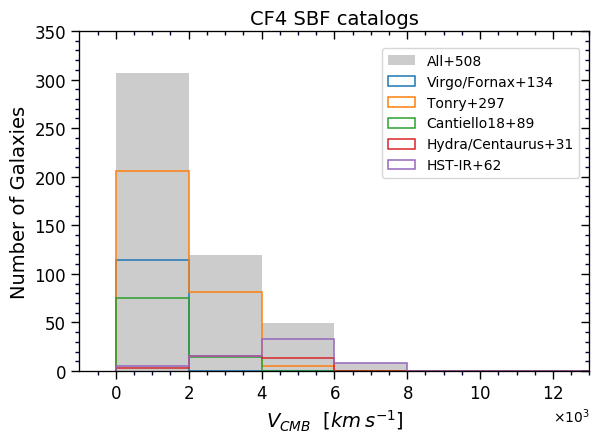

In [20]:
fig = plt.figure(figsize=(6, 4), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])

bins=np.arange(0,16000,2000)

val = df.Vcmb.values
ax.hist(val, bins=bins, histtype='bar', label='All+'+str(len(val)), color='k', lw=1.7, alpha=0.2) 

val = df[~df["Vcmb_VirFor"].isna()]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='Virgo/Fornax+'+str(len(val)), lw=1.1) 

val = df[~df["Vcmb_Tonry"].isna()]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='Tonry+'+str(len(val)), lw=1.1) 

val = df[~df["Vcmb_Cantiello18"].isna()]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='Cantiello18+'+str(len(val)), lw=1.1) 

val = df[~df["Vcmb_HydCen"].isna()]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='Hydra/Centaurus+'+str(len(val)), lw=1.1) 

val = df[~df["Vcmb_HSTIR"].isna()]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='HST-IR+'+str(len(val)), lw=1.1) 

# ax.set_yscale('log')
x_ax, y_ax = set_axes(ax, [-1000,13000], [0,350], fontsize=12, inout='out')


ax.set_xlabel(r"$V_{CMB}$"+"  "+r'$[km \/ s^{-1}]$', fontsize=14)
ax.set_ylabel("Number of Galaxies", fontsize=14)

ax.legend(bbox_to_anchor=(0.58, 0.97), loc='upper left', fontsize=10)

x_ax.set_xticks(np.arange(0, 14000, step=2000))
ax.set_xticks(np.arange(0, 14000, step=2000))


ax.set_title("CF4 SBF catalogs", fontsize=14, pad=5)

ax.xaxis.set_major_formatter(OOMFormatter(3, "%d"))
ax.ticklabel_format(axis='x', style='sci')

In [21]:
import copy

df_all = copy.deepcopy(df)



In [22]:
import sys
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import  lines
from matplotlib import rc, rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Polygon, Ellipse
import numpy as np
from math import *
from time import time
import wl_to_rgb as col
import random
from astropy.io import ascii
from astropy.table import Table, Column 
import pyfits
import pylab as py
from astropy import coordinates as coord
from astropy import units as unit
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.patches as mpatches

from matplotlib import *

/home/ehsan/anaconda3/envs/py2/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [23]:
df = df_all[df_all["Vgrp"]<16000]

vel = df.Vcmb.values
vel = df.Vgrp.values

print np.min(vel), np.max(vel)


-497.5846627337156 7523.403989469046


In [25]:
df.to_csv("All_CF4_4aitoff.csv")

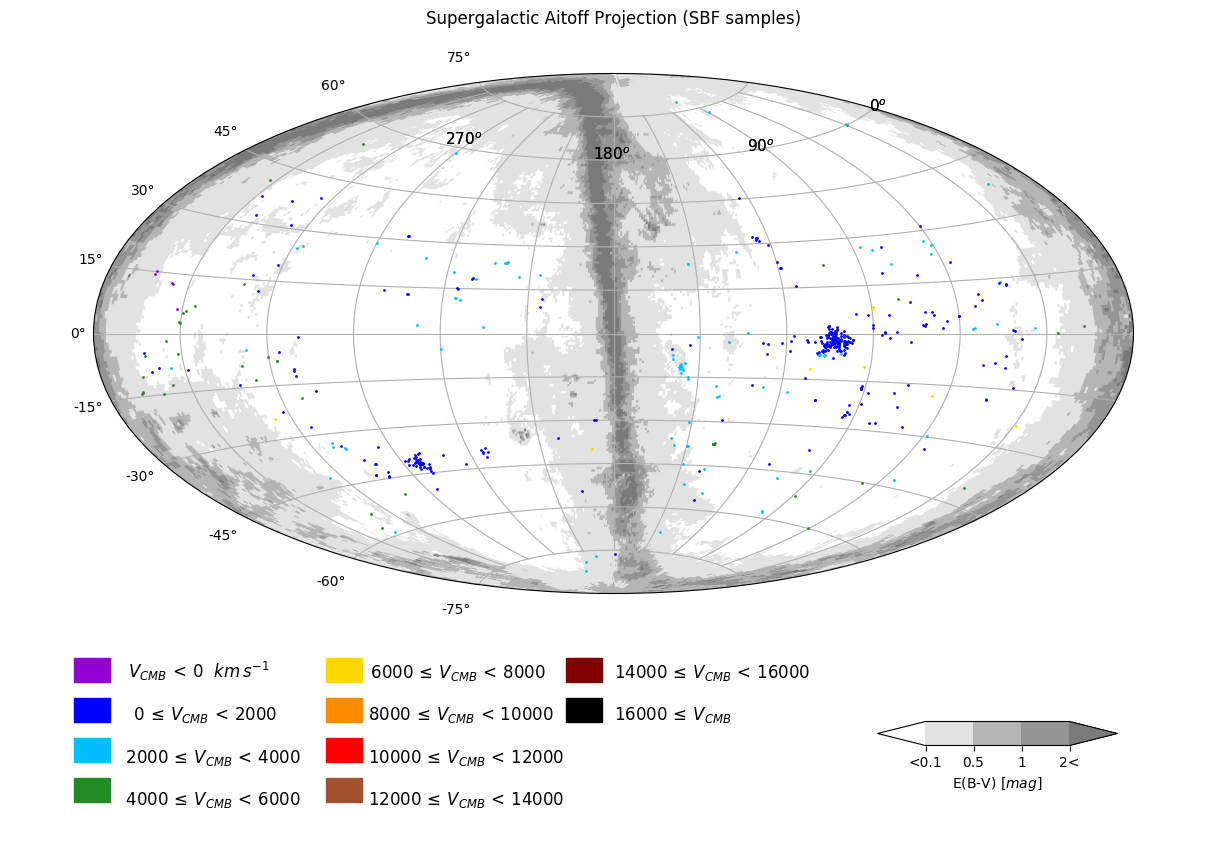

In [26]:
l0 = 180

deg = 0.8
a = pyfits.open('EBV.0.8.deg.fits')
d = a[1].data


SGL  = d['SGL']
SGB  = d['SGB']
EBV = d['EBV']

fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection="aitoff")
plt.title("Supergalactic Aitoff Projection (SBF samples)", y=1.08)
ax.grid(True)
ax.set_xticklabels([])
plt.subplots_adjust(top=0.95, bottom=0.3, right=0.95, left=0.05)

ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')


ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')  
################################################################ 
################################################################ 
def xymap_aitoff(x, y):
  
    while x > 360:
        x-=360
    while x < 0:
        x+=360

    x0 = (180.-x)*pi/180.
    y0 = y*pi/180.
  
    return x0, y0
################################################################ 

def esn_aitoff_patch(ax, x0, y0, d, color='blue'):

    vertices = []
    x, y = xymap_aitoff(x0,y0) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0) 
    vertices.append([x,y]) 
    ax.add_patch(Polygon(vertices, closed=True, fill=True, color=color))


jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(len(SGB)):
    if EBV[i]>2.0: val = 3
    elif EBV[i]>1.0: val = 2.5
    elif EBV[i]>0.5: val= 2.0
    elif EBV[i]<=0.5 and EBV[i]>0.1: val= 1.0
    elif EBV[i]<0.1: val= 0
    else: val= 0
    colorVal = scalarMap.to_rgba(val)
    esn_aitoff_patch(ax, SGL[i], SGB[i], deg, color=colorVal)

    
    
# N = len(SGL)
# X = np.zeros(N)
# Y = np.zeros(N)
# for i in range(N):
#     X[i], Y[i] = xymap_aitoff(SGL[i], SGB[i])    
# ax.scatter(X, Y, marker='.', color='black')


sgl_gal = df.sgl.values
sgb_gal = df.sgb.values
N = len(sgl_gal)
X = np.zeros(N)
Y = np.zeros(N)
for i in range(N):
    X[i], Y[i] = xymap_aitoff(sgl_gal[i], sgb_gal[i])
    
############################################
    
# vel_col = np.zeros(N)   
# Velocity = df.Vcmb.values
# for i, v in enumerate(vel):
#     vel_col[i] = 0
#     if v<=0:
#         vel_col[i] = 0.1
#     elif v>=11000:
#         vel_col[i] = 1
#     else:
#         vel_col[i] = 0.1+0.9*v/11000.
    
# colours = pl.cm.nipy_spectral(vel_col)

############################################
col_pallet = ['darkviolet', 'blue', 'deepskyblue', 'forestgreen', 'gold', 'darkorange', 'red', 'sienna', 'maroon', 'black']
vel_pallet = [-100000, 0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 20000]
def color_table(Velocity):
    colours = []
    for j, v in enumerate(Velocity):
        col = "white"
        for i in range(len(vel_pallet)-1):
            if vel_pallet[i] <= v and v < vel_pallet[i+1]:
                col = col_pallet[i]
                break
        colours.append(col)
    return colours

colours = color_table(df.Vgrp.values)
############################################

ax2 = plt.axes([0,0,1,1], facecolor=(1,1,1,0))
ax2.set_axis_off()
ax2.set_xticks([])
ax2.set_yticks([])
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.annotate(r"$\/\/ V_{CMB} \/ < \/ 0 \/\/\/\/ km\/ s^{-1}  $", (0.1,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$ \/\/\/\/ 0 \/ \leq \/ V_{CMB} \/ < \/ 2000$', (0.1,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 2000 \/ \leq \/ V_{CMB} \/ < \/ 4000$', (0.1,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 4000 \/ \leq \/ V_{CMB} \/ < \/ 6000$', (0.1,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 6000 \/ \leq \/ V_{CMB} \/ < \/ 8000$', (0.30,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$8000 \/ \leq \/ V_{CMB} \/ < \/ 10000$', (0.30,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$10000 \/ \leq \/ V_{CMB} \/ < \/ 12000$', (0.30,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$12000 \/ \leq \/ V_{CMB} \/ < \/ 14000$', (0.30,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$14000 \/ \leq \/ V_{CMB} \/ < \/ 16000$', (0.5,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$16000 \/ \leq \/ V_{CMB}$', (0.50,0.2-0.05), xycoords='figure fraction', size=12, color='black')

try:
    p = 0
    for m in [0.1,0.31,0.51]:
        for n in [0.19,0.19-0.05,0.19-2*0.05,0.19-3*0.05]:
            ax2.add_patch(patches.Rectangle((m-0.05, n), 0.03, 0.03, color=col_pallet[p]))
            p+=1
    # ax2.add_patch(patches.Rectangle((0.71-0.05, 0.19), 0.03, 0.03, color=col_pallet[p]))
except:
    pass
############################################
################################################################ 
jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
ax3 = fig.add_axes([0.720, 0.11, 0.2, 0.03])
cols = []
bounds = [0,1,2,3]
#cols.append(scalarMap.to_rgba(0))
cols.append(scalarMap.to_rgba(1.0))
cols.append(scalarMap.to_rgba(2.0))
cols.append(scalarMap.to_rgba(2.5))
#cols.append(scalarMap.to_rgba(3.0))



cm = colors.ListedColormap(cols)

cm.set_over(scalarMap.to_rgba(3.0))
cm.set_under(scalarMap.to_rgba(0))

cNorm  = colors.BoundaryNorm(bounds, cm.N)
cbar = colorbar.ColorbarBase(ax3, cmap=cm, norm=cNorm, orientation='horizontal',ticks=bounds, boundaries=[-1]+bounds+[4],extend='both',extendfrac='auto')
cbar.set_ticks(bounds)
cbar.ax.tick_params(labelsize=10) 
cbar.ax.set_xticklabels(['<0.1','0.5','1','2<'])  # horizontal colorbar

cbar.set_label('E(B-V) '+r'$[mag]$')
################################################################   

for i, c in enumerate(colours):
    ax.plot([X[i]], [Y[i]], color=c, marker='.', ms=2)
    